In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

#### Вспомогательные функции

In [2]:
def gauss(x: float, sigma: float) -> float:
    return 1 / np.sqrt(2 * np.pi * sigma ** 2) * \
        np.exp(- x ** 2 / (2 * sigma ** 2))


def to_grayscale(img: np.ndarray) -> np.ndarray:
    return np.clip(img, 0, 255).astype(np.uint8)


def show_gray_img(img: np.ndarray) -> None:
    plt.imshow(img, cmap=plt.cm.gray, aspect='auto')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#### Шумы

In [3]:
def gaussian_noise(img: np.ndarray, scale: float = 10) -> np.ndarray:
    noise = np.random.normal(0, scale, img.shape)
    return to_grayscale(img + noise)


def impulse_noise(img: np.ndarray, percent: float) -> np.ndarray:
    points = np.random.uniform(0, 1, img.shape)
    noise = np.random.randint(0, 255, img.shape, np.uint8)
    return np.where(points < percent, noise, img)


def salt_and_pepper_noise(img: np.ndarray, percent: float) -> np.ndarray:
    points = np.random.uniform(0, 1, img.shape)
    noise = np.random.choice((0, 255), img.shape).astype(np.uint8)
    return np.where(points < percent, noise, img)


def quantization_noise(img: np.ndarray, percent: float,
                       scale: int = 50) -> np.ndarray:
    points = np.random.uniform(0, 1, img.shape)
    noise = np.uint8(np.round(img / scale) * scale)
    return np.where(points < percent, noise, img)

#### Фильтры (операторы выделения) краёв

In [4]:
def roberts_filter(img: np.ndarray) -> np.ndarray:
    img = img.astype(int)
    kernels = [
        [
            [-1, 0],
            [ 0, 1],
        ],
        [
            [0, -1],
            [1,  0],
        ],
    ]
    return to_grayscale(
        np.sqrt(
            ndimage.convolve(img, kernels[0]) ** 2
            + ndimage.convolve(img, kernels[1]) ** 2
        )
    )


def prewitt_filter(img: np.ndarray) -> np.ndarray:
    img = img.astype(int)
    kernels = [
        [
            [-1, -1, -1],
            [ 0,  0,  0],
            [ 1,  1,  1],
        ],
        [
            [-1, 0, 1], 
            [-1, 0, 1], 
            [-1, 0, 1],
        ],
    ]
    return to_grayscale(
        np.sqrt(
            ndimage.convolve(img, kernels[0]) ** 2
            + ndimage.convolve(img, kernels[1]) ** 2
        )
    )


def sobel_filter(img: np.ndarray) -> np.ndarray:
    img = img.astype(int)
    kernels = [
        [
            [-1, -2, -1], 
            [ 0,  0,  0], 
            [ 1,  2,  1],
        ],
        [
            [-1, 0, 1], 
            [-2, 0, 2], 
            [-1, 0, 1],
        ],
    ]
    return to_grayscale(
        np.sqrt(
            ndimage.convolve(img, kernels[0]) ** 2
            + ndimage.convolve(img, kernels[1]) ** 2
        )
    )


def laplace_filter(img: np.ndarray) -> np.ndarray:
    img = img.astype(int)
    kernel = [
        [ 0, -1,  0], 
        [-1,  4, -1],
        [ 0, -1,  0],
    ]
    return ndimage.convolve(img, kernel)

#### Фильтры устанения шумов

In [5]:
def gaussian_filter(img: np.ndarray, sigma: float = 1.0) -> np.ndarray:
    r = int(np.ceil(3 * sigma))
    w = 2 * r + 1
    kernel = np.zeros((w, 1))
    for i in range(w):
        kernel[i, 0] = gauss(i - r, sigma)

    return to_grayscale(
        ndimage.convolve(ndimage.convolve(img, kernel), kernel.T))


def median_filter(img: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    n = kernel_size // 2
    copy = cv2.copyMakeBorder(img, n, n, n, n, cv2.BORDER_REPLICATE)
    n = 2 * n + 1
    res = np.zeros(img.shape, np.uint8)

    for i, row in enumerate(img):
        for j, _ in enumerate(row):
            res[i, j] = np.median(copy[i : i + n, j : j + n])

    return res


def bilateral_filter(img: np.ndarray, sigma_s: float = 1.0,
                     sigma_r: float = 1.0, kernel_size: int = 3) -> np.ndarray:
    img = img.astype(np.int32)
    n = kernel_size // 2
    copy = cv2.copyMakeBorder(img, n, n, n, n, cv2.BORDER_REPLICATE)
    res = np.zeros(img.shape)
    k = np.arange(-n, img.shape[0] + n)
    l = np.arange(-n, img.shape[1] + n)
    n = 2 * n + 1

    for i, row in enumerate(img):
        for j, elem in enumerate(row):
            slice = copy[i : i + n, j : j + n]
            prod = np.exp(
                -((i - k[i : i + n]) ** 2 + (j - l[j : j + n]) ** 2)
                / (2 * sigma_s ** 2)
                - np.abs(elem - slice) / (2 * sigma_r ** 2)
            )
            res[i, j] = np.sum(prod * slice) / np.sum(prod)

    return to_grayscale(res)

#### Изображение

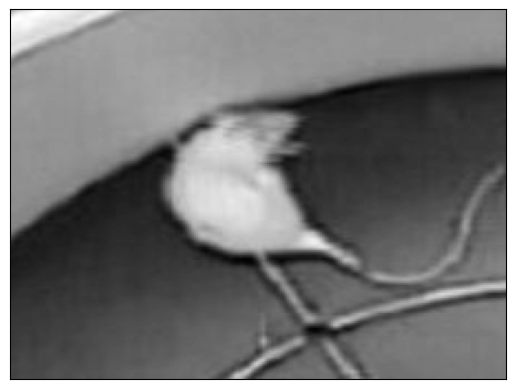

In [6]:
img = cv2.imread('OFT_control_04$000176&03_F00849_u_.bmp')[:,:,1]
show_gray_img(img)

#### Зашумление

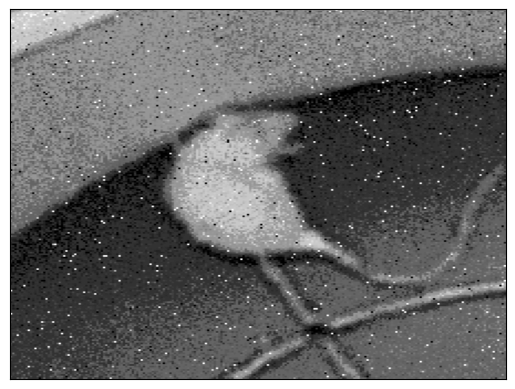

In [7]:
noised = gaussian_noise(img, 10)
noised = quantization_noise(noised, 0.5)
noised = impulse_noise(noised, 0.01)
noised = salt_and_pepper_noise(noised, 0.01)
show_gray_img(noised)

#### Устранение шумов

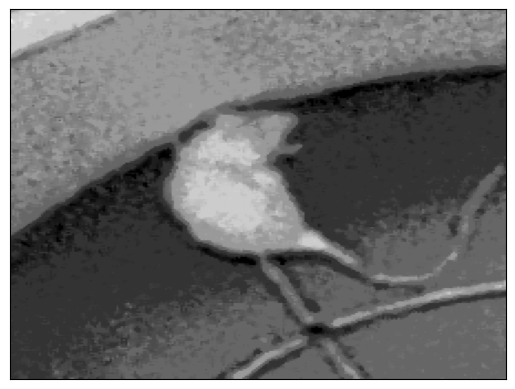

In [8]:
# Устранение импульсного шума и шума соль-перец при помощи медианного фильтра
no_impulse = median_filter(noised, 3)
show_gray_img(no_impulse)

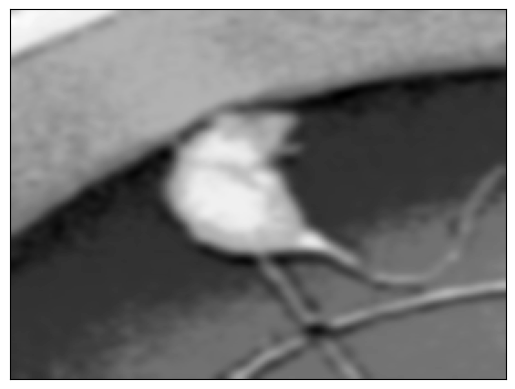

In [9]:
# Удаление гауссовского шума и шума квантования
cleared = gaussian_filter(no_impulse, 2)
show_gray_img(cleared)

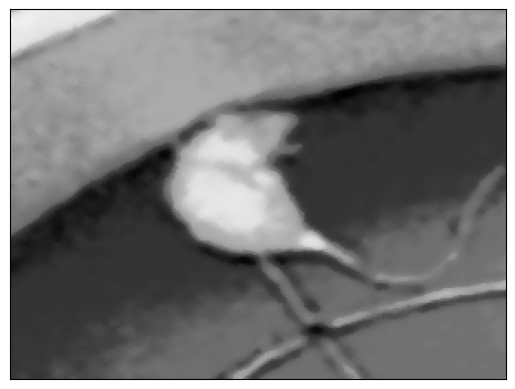

In [10]:
# Или можно воспользоваться биллатеральным фильтром для большей резкости
# изображения
cleared = bilateral_filter(no_impulse, 5, 5, 7)
show_gray_img(cleared)

#### Поиск краёв

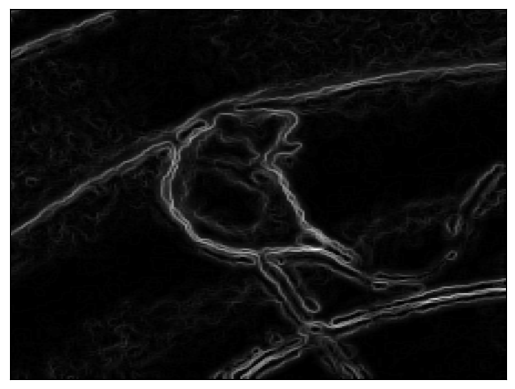

In [11]:
# Оператор Робертса
show_gray_img(roberts_filter(cleared))

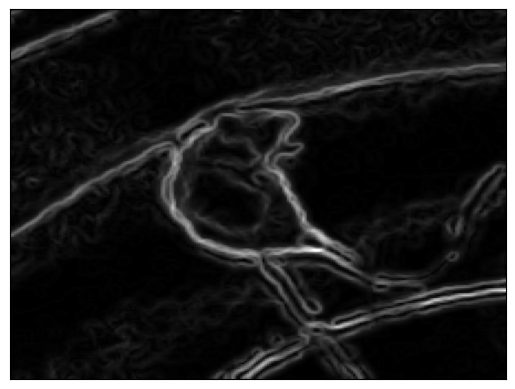

In [12]:
# Оператор Прюит
show_gray_img(prewitt_filter(cleared))

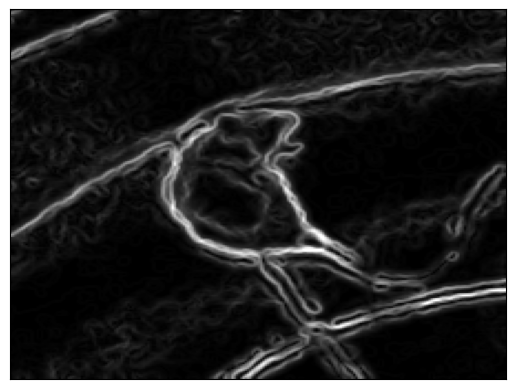

In [13]:
# Оператор Собеля
show_gray_img(sobel_filter(cleared))

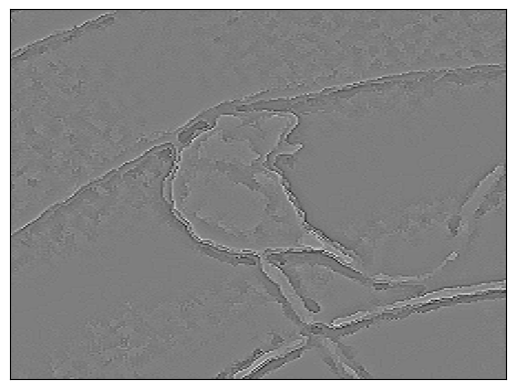

In [14]:
# Оператор Лапласа
laplace = laplace_filter(cleared)
show_gray_img(laplace)

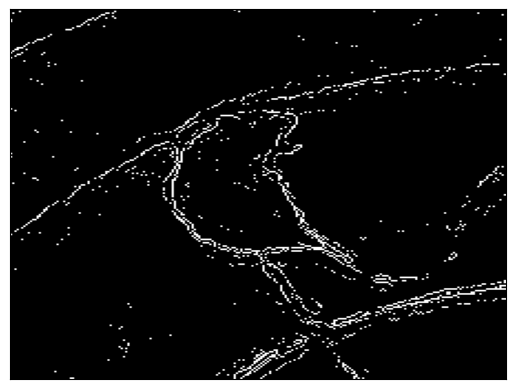

: 

In [15]:
show_gray_img(laplace > 10)